In [2]:
!pip install python_speech_features
!pip install python-dotenv 

In [3]:
!pip install keras --upgrade

     |████████████████████████████████| 378kB 4.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
# !pip list librosa

In [3]:
import numpy as np
import pandas as pd
from python_speech_features import mfcc
import os
# import tensorflow as tf
from keras import layers
from keras import models
import keras
from keras import optimizers
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import sys
sys.path.append('/content/drive/My Drive/cs577- Deep learning/deepMusic/')
import utils
from sklearn import preprocessing
import librosa
import matplotlib.pyplot as plt
import librosa.display
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)



Using TensorFlow backend.


In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_IDs, labels, loader, audio_dir, batch_size=32, dim=(32, 32, 32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.loader = loader
        self.audio_dir = audio_dir

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # print(list_IDs_temp)

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # # Store sample
            # signal, rate = self.loader.load(utils.get_audio_path(self.audio_dir, ID))
            # sample = signal[:rate]
            
            # # Shorten the sample to 10 secs
            # ran_index = np.random.randint(0, signal.shape[0] - int(rate / 10))
            # sample = signal[ran_index:ran_index + int(rate / 10)]
            # # print(f'shape of sample -> {sample.shape}')

            # normalized_X = preprocessing.normalize(mfcc(sample, rate, numcep=13, nfilt=26, nfft=1103).T)
            # temp = np.array(normalized_X)
            # rshaped_X = temp.reshape(temp.shape[0], temp.shape[1], 1)
            # X[i,] = rshaped_X

            # Librosa version mel spectrogram
            signal, sr = self.loader.load(utils.get_audio_path(self.audio_dir, ID))
            signal = signal.astype(float)
            # Shorten the sample to 10 secs
            ran_index = np.random.randint(0, signal.shape[0] - int(sr / 1))
            sample = signal[ran_index:ran_index + int(sr / 1)]
            # print(sr)
            spect = librosa.feature.melspectrogram(y=sample, sr=sr, n_mels=64,fmax=8000)
            
            # plt.figure(figsize=(10, 5))
            # librosa.display.specshow(spect.T, y_axis='mel', x_axis='time')
            # plt.colorbar(format='%+2.0f dB')
            # plt.title('Test Melspectogram')
            # plt.show()

            temp = np.array(spect)
            rshaped_X = temp.reshape(temp.shape[0], temp.shape[1], 1)
            X[i,] = rshaped_X

            # X[i,] = np.array(spect)

            # Store class
            y[i] = self.labels.loc[ID].to_numpy()

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)


In [0]:
def plot_mel_spect(loader,audio_dir,ID):
    signal, sr = loader.load(utils.get_audio_path(audio_dir, ID))
    signal = signal.astype(float)
    # Shorten the sample to 10 secs
    ran_index = np.random.randint(0, signal.shape[0] - int(sr / 1))
    sample = signal[ran_index:ran_index + int(sr / 1)]
    spect = librosa.feature.melspectrogram(y=sample, sr=sr, n_mels=64,fmax=8000)
    
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(spect.T, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Test Melspectogram')
    plt.show()

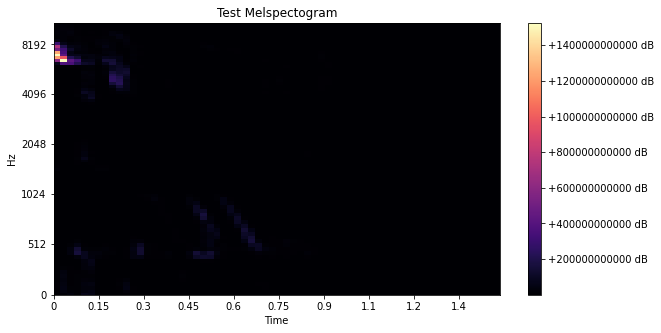

(10, 64, 87, 1)
[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [25]:
# # Train and Validate
ff_loader = utils.FfmpegLoader()

# Plot mel spect for audio file with ID 2
plot_mel_spect(ff_loader,AUDIO_DIR,2)

# METHOD 2 - DATAGENERATOR
# Parameters
params = {'dim': (64, 87),
          'batch_size': 10,
          'n_classes': 8,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(train.index.values, labels_onehot,ff_loader, AUDIO_DIR, **params)
x , y = training_generator.__getitem__(0)
print(x.shape)
# print(train.loc[ID]['track_genre_top'])
print(y)

In [7]:

# print(keras.__version__)
root_folder = "/content/drive/My Drive/cs577- Deep learning/deepMusic/"
AUDIO_DIR = root_folder + 'fma_small'

# Read data
tracks = pd.read_csv(root_folder+'fma_metadata/subset_small.csv', index_col=0)
print(tracks['set_split'].shape)
train = tracks.loc[tracks['set_split'] == 'training']
val = tracks.loc[tracks['set_split'] == 'validation']
test = tracks.loc[tracks['set_split'] == 'test']
print(f'train -> {train.columns}')



(7995,)
train -> Index(['album_comments', 'album_date_created', 'album_date_released',
       'album_engineer', 'album_favorites', 'album_id', 'album_information',
       'album_listens', 'album_producer', 'album_tags', 'album_title',
       'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens

In [8]:

# Check which genres are present
genres = list(LabelEncoder().fit(train['track_genre_top']).classes_)
print('Top genres ({}): {}'.format(len(genres), genres))

# one hot encode y
# labels_onehot = LabelBinarizer().fit_transform(tracks['track_genre_top'])
# labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)
# print(f'labels_onehot -> {labels_onehot.head()}')

labels_onehot = np.asarray(LabelEncoder().fit_transform(tracks['track_genre_top']))
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)
print(f'labels_onehot -> {labels_onehot.head()}')
# print(f'label type {labels_onehot.shape}')

# For local training purposes
train = train.head(100)
val = val.head(100)
test = test.head(100)
print(f'test.index.values -> {len(test.index.values)}')


Top genres (8): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
labels_onehot ->           0
track_id   
2         3
5         3
10        6
140       2
141       2
test.index.values -> 100


In [0]:

def gen_model():
  # Input shape is this because 13->numcep in mfcc function and 9 -> number of frames considered
  # input_shape = (13, 9, 1)
  input_shape = (64, 87, 1)

  # Network Architecture
  # tf.keras.backend.clear_session()

  model = models.Sequential()

  model.add(layers.Conv2D(16, (3, 3), activation='relu',
                          strides=(1, 1), padding='same',
                          input_shape=input_shape))
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          strides=(1, 1), padding='same',
                          ))
  model.add(layers.MaxPool2D(2, 2))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(8, activation='softmax'))
  model.summary()

  # optimizer = optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
  optimizer = optimizers.Adam(lr=0.01)
  model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
  return model



In [0]:

# # Train and Validate
ff_loader = utils.FfmpegLoader()

# METHOD 2 - DATAGENERATOR
# Parameters
params = {'dim': (13, 9),
          'batch_size': 10,
          'n_classes': 8,
          'n_channels': 1,
          'shuffle': True}


In [0]:

def plot_epocs_graph(history_dict):
    loss_vals = history_dict['loss']
    val_loss_vals = history_dict['val_loss']
    epochs = range(1, len(history_dict['acc']) + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_vals, 'g', label='Training Loss')
    plt.plot(epochs, val_loss_vals, 'b', label='Validation Loss')
    plt.title("Training and validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc_vals = history_dict['acc']
    val_acc_vals = history_dict['val_acc']
    plt.plot(epochs, acc_vals, 'g', label='Training accuracy')
    plt.plot(epochs, val_acc_vals, 'b', label='Validation accuracy')
    plt.title("Training and validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig("../doc/graphs/val_loss_acc_epochs_before1_task2.png")
    # plt.savefig("../doc/graphs/val_loss_acc_epochs_after1_task2.png")
    plt.show()
    return

In [18]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0-rc2
tf.keras.__version__ is: 2.3.0-tf


In [26]:
# cnn
# model = gen_model()

# CRNN
# input_shape = (64,18,1)
# model_input = layers.Input(input_shape, name='input')
# model = conv_recurrent_model_build(model_input,input_shape)

# CNN by mdeff
# input_shape = (64,18,1)
# model = getMdeff_model(input_shape)

# Another trial
model = MusicTaggerCNN(weights=None, input_tensor=(64,87,1))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.load_weights("/content/crnn_net_gru_adam_ours_epoch_40.h5")
model.summary()



# Generators
training_generator = DataGenerator(train.index.values, labels_onehot,ff_loader,AUDIO_DIR, **params)
validation_generator = DataGenerator(val.index.values, labels_onehot,ff_loader,AUDIO_DIR, **params)
test_generator = DataGenerator(test.index.values, labels_onehot,ff_loader,AUDIO_DIR, **params)

# Train model on dataset
train_val_history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=5,
                    # steps_per_epoch = 20,
                    use_multiprocessing=True, workers=1)
history_dict = train_val_history.history
plot_epocs_graph(history_dict=history_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv1", trainable=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=3, name="bn1", trainable=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), name="conv2", trainable=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=3, name="bn2", trainable=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), name="conv3", trainable=False, padding="same")`
/usr/local/lib/python3.6/dist-pack

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 87, 1)         0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 64, 87, 1)         256       
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 87, 32)        320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 64, 87, 32)        128       
_________________________________________________________________
elu_10 (ELU)                 (None, 64, 87, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 21, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 21, 128)       3699

KeyError: ignored

In [0]:
def getMdeff_model(input_shape):
  model = models.Sequential()
  # model.add(layers.Reshape((-1, 1), input_shape=input_shape))
  # print(model.output_shape)

  model.add(layers.Conv1D(128, 512, subsample_length=512,input_shape=input_shape))
  # print(model.output_shape)
  model.add(layers.Activation("relu"))

  model.add(layers.Conv1D(32, 8))
  # print(model.output_shape)
  model.add(layers.Activation("relu"))
  model.add(layers.MaxPooling1D(4))

  model.add(layers.Conv1D(32, 8))
  # print(model.output_shape)
  model.add(layers.Activation("relu"))
  model.add(layers.MaxPooling1D(4))

  # print(model.output_shape)
  #model.add(Dropout(0.25))
  model.add(layers.Flatten())
  print(model.output_shape)
  model.add(layers.Dense(100))
  model.add(layers.Activation("relu"))
  # print(model.output_shape)
  model.add(layers.Dense(labels_onehot.shape[1]))
  model.add(layers.Activation("softmax"))
  # print(model.output_shape)

  optimizer = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
  #optimizer = keras.optimizers.Adam()#lr=1e-5)#, momentum=0.9, nesterov=True)
  model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
  return model

In [0]:
num_classes = 8
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001


def conv_recurrent_model_build(model_input,input_shape):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = layers.Conv2D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1),
                data_format='channels_last',
                strides=1, padding='same',
                input_shape = input_shape
            )(layer)
        layer = layers.BatchNormalization(momentum=0.9)(layer)
        layer = layers.Activation('relu')(layer)
        layer = layers.MaxPooling2D(pool_size=2,padding='same',
                data_format='channels_last',)(layer)
        layer = layers.Dropout(0.4)(layer)
    
    # ## LSTM Layer
    # layer = layers.LSTM(LSTM_COUNT, return_sequences=False)(layer)
    # layer = layers.Dropout(0.4)(layer)
    
    # ## Dense Layer
    # layer = layers.Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    # layer = layers.Dropout(0.4)(layer)
    
    # ## Softmax Output
    # layer = layers.Dense(num_classes)(layer)
    # layer = layers.Activation('softmax', name='output_realtime')(layer)

    model_output = layer
    model = models.Model(model_input, model_output)
    
    
    opt = optimizers.Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['acc']
        )
    
    print(model.summary())
    return model

In [0]:
# # Test the network
# print("Testing network on test set...")
# test_history = model.evaluate_generator(test_generator,use_multiprocessing=True, workers=1)

# print(test_history)

In [0]:
from __future__ import print_function
from __future__ import absolute_import

from keras import backend as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.utils.data_utils import get_file
from keras.layers import Input, Dense

In [0]:
def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False


def MusicTaggerCNN(weights='msd', input_tensor=None):
    '''Instantiate the MusicTaggerCNN architecture,
    optionally loading weights pre-trained
    on Million Song Dataset. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.
    For preparing mel-spectrogram input, see
    `audio_conv_utils.py` in [applications](https://github.com/fchollet/keras/tree/master/keras/applications).
    You will need to install [Librosa](http://librosa.github.io/librosa/)
    to use it.
    # Arguments
        weights: one of `None` (random initialization)
            or "msd" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        include_top: whether to include the 1 fully-connected
            layer (output layer) at the top of the network.
            If False, the network outputs 256-dim features.
    # Returns
        A Keras model instance.
    '''
    if weights not in {'msd', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `msd` '
                         '(pre-training on Million Song Dataset).')

    input_shape = (64,87,1)

    if input_tensor is None:
        melgram_input = Input(shape=input_shape)
    else:
        melgram_input = Input(shape=input_tensor)


    channel_axis = 3
    freq_axis = 2
    time_axis = 1

    # Input block
    x = BatchNormalization(axis=time_axis, name='bn_0_freq', trainable=False)(melgram_input)

    # Conv block 1
    x = Convolution2D(32, 3, 3, border_mode='same', name='conv1', trainable=False)(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn1', trainable=False)(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 4), name='pool1', trainable=False)(x)

    # Conv block 2
    x = Convolution2D(128, 3, 3, border_mode='same', name='conv2', trainable=False)(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn2', trainable=False)(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 4), name='pool2')(x)

    # Conv block 3
    x = Convolution2D(128, 3, 3, border_mode='same', name='conv3', trainable=False)(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn3', trainable=False)(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 4), name='pool3')(x)

    # # Conv block 4
    # x = Convolution2D(192, 3, 3, border_mode='same', name='conv4', trainable=False)(x)
    # x = BatchNormalization(axis=channel_axis, mode=0, name='bn4', trainable=False)(x)
    # x = ELU()(x)
    # x = MaxPooling2D(pool_size=(3, 5), name='pool4', trainable=False)(x)

    # # Conv block 5
    # x = Convolution2D(256, 3, 3, border_mode='same', name='conv5')(x)
    # x = BatchNormalization(axis=channel_axis, mode=0, name='bn5')(x)
    # x = ELU()(x)
    # x = MaxPooling2D(pool_size=(4, 4), name='pool5')(x)

    # Output
    x = Flatten(name='Flatten_1')(x)

    if weights is None:
        # Create model
        x = Dense(8, activation='softmax', name='output')(x)
        model = Model(melgram_input, x)
        return model
    else:
        # Load input
        x = Dense(50, activation='sigmoid', name='output')(x)
        # if K.image_dim_ordering() == 'tf':
        #     raise RuntimeError("Please set image_dim_ordering == 'th'."
        #                        "You can set it at ~/.keras/keras.json")
        # Create model
        initial_model = Model(melgram_input, x)
        initial_model.load_weights('/content/music_tagger_cnn_weights_tensorflow.h5',
                                   by_name=True)

        # Eliminate last layer
        pop_layer(initial_model)

        # Add new Dense layer
        last = initial_model.get_layer('Flatten_1')
        preds = (Dense(10, activation='sigmoid', name='preds'))(last.output)
        model = Model(initial_model.input, preds)

        return model